In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import pickle
import yaml
import os
import scipy

In [2]:
data = pd.read_parquet('./data/preprocessed.parquet')
data_cfg_path = 'data/dataset_cfg.yaml'
positive_outcome_class = 1

In [3]:
with open(data_cfg_path, 'r') as infile:
    data_cfg = yaml.safe_load(infile)

if "lambda" not in data_cfg:
    data_cfg["lambda"] = 1

with open('./synthetic_experts/cfg.yaml', 'r') as infile:
    cfg = yaml.safe_load(infile)

LABEL_COL = data_cfg['data_cols']['label']

preds = pd.read_parquet(f'./synthetic_experts/expert_team/expert_predictions.parquet').loc[data.index]

metrics = pd.DataFrame(index = preds.columns, columns = ['TPR','FNR','FPR','TNR','Cost'])

for expert in preds.columns:
    for protected_feature in data_cfg['data_cols']['protected']:
        if protected_feature["type"] == 'categorical':
            tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_pred = preds[expert].loc[data[protected_feature['feature']] == protected_feature['protected_class']], y_true = data[LABEL_COL].loc[data[protected_feature['feature']] == protected_feature['protected_class']]).ravel()
            tn_np, fp_np, fn_np, tp_np = confusion_matrix(y_pred = preds[expert].loc[data[protected_feature['feature']] != protected_feature['protected_class']], y_true = data[LABEL_COL].loc[data[protected_feature['feature']] != protected_feature['protected_class']]).ravel()
        else:
            if protected_feature["protected_class"] == 'higher':
                tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_pred = preds[expert].loc[data[protected_feature['feature']] >= protected_feature['protected_threshold']], y_true = data[LABEL_COL].loc[data[protected_feature['feature']] >= protected_feature['protected_threshold']]).ravel()
                tn_np, fp_np, fn_np, tp_np = confusion_matrix(y_pred = preds[expert].loc[data[protected_feature['feature']] < protected_feature['protected_threshold']], y_true = data[LABEL_COL].loc[data[protected_feature['feature']] < protected_feature['protected_threshold']]).ravel()
            elif protected_feature["protected_class"] == 'lower':
                tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_pred = preds[expert].loc[data[protected_feature['feature']] <= protected_feature['protected_threshold']], y_true = data[LABEL_COL].loc[data[protected_feature['feature']] <= protected_feature['protected_threshold']]).ravel()
                tn_np, fp_np, fn_np, tp_np = confusion_matrix(y_pred = preds[expert].loc[data[protected_feature['feature']] > protected_feature['protected_threshold']], y_true = data[LABEL_COL].loc[data[protected_feature['feature']] > protected_feature['protected_threshold']]).ravel()
        
        fpr_prot = fp_p/(fp_p+tn_p)
        fnr_prot = fn_p/(fn_p+tp_p)
        tpr_prot = tp_p/(tp_p+fn_p)
        tnr_prot = tn_p/(tn_p+fp_p)
        
        fpr_not_prot = fp_np/(fp_np+tn_np)
        fnr_not_prot = fn_np/(fn_np+tp_np)
        tpr_not_prot = tp_np/(tp_np+fn_np)
        tnr_not_prot = tn_np/(tn_np+fp_np)
        
        metrics.loc[expert,f'TPR_{protected_feature["protected_class"]}'] = tpr_prot
        metrics.loc[expert,f'FPR_{protected_feature["protected_class"]}'] = fpr_prot
        metrics.loc[expert,f'TNR_{protected_feature["protected_class"]}'] = tnr_prot
        metrics.loc[expert,f'FNR_{protected_feature["protected_class"]}'] = fnr_prot

        metrics.loc[expert,f'TPR_not_{protected_feature["protected_class"]}'] = tpr_not_prot
        metrics.loc[expert,f'FPR_not_{protected_feature["protected_class"]}'] = fpr_not_prot
        metrics.loc[expert,f'TNR_not_{protected_feature["protected_class"]}'] = tnr_not_prot
        metrics.loc[expert,f'FNR_not_{protected_feature["protected_class"]}'] = fnr_not_prot

        if positive_outcome_class == 1:
            if fnr_not_prot == 0:
                metrics.loc[expert,f'Predictive_Equality_{protected_feature["feature"]}'] = np.inf
            else:
                metrics.loc[expert,f'Predictive_Equality_{protected_feature["feature"]}'] = fnr_not_prot/fnr_prot
        else:
            if fpr_not_prot == 0:
                metrics.loc[expert,f'Predictive_Equality_{protected_feature["feature"]}'] = np.inf
            else:
                metrics.loc[expert,f'Predictive_Equality_{protected_feature["feature"]}'] = fpr_not_prot/fpr_prot

for expert in preds.columns:
    tn, fp, fn, tp = confusion_matrix(y_pred = preds[expert], y_true = data[LABEL_COL]).ravel()
    metrics.loc[expert,'TPR'] = tp/(tp+fn)
    metrics.loc[expert,'FPR'] = fp/(fp+tn)
    metrics.loc[expert,'TNR'] = tn/(tn+fp)
    metrics.loc[expert,'FNR'] = fn/(fn+tp)
    metrics.loc[expert,'Cost'] = (fn + data_cfg["lambda"]*fp)/(fn+fp+tn+tp)


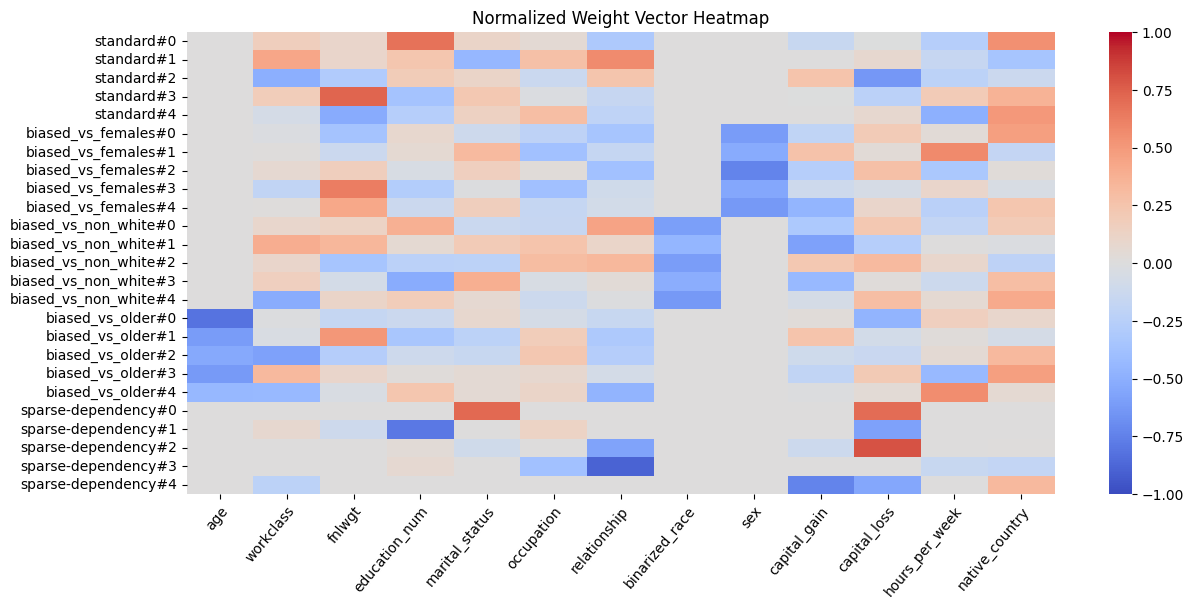

In [4]:
prop = pd.read_parquet(f'./synthetic_experts/expert_team/expert_parameters.parquet')
w = prop.drop(columns =['fp_beta', 'fn_beta', 'alpha'])
w = w.div(np.sqrt(np.square(w).sum(axis=1)), axis = 0)

f, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(w, robust=True, cmap = 'coolwarm', vmax = 1, vmin = -1, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title("Normalized Weight Vector Heatmap")
plt.xticks(rotation = 50, rotation_mode = 'anchor', ha = 'right')
plt.show()

Text(0.5, 1.0, 'Expert Performance - FPR vs FNR')

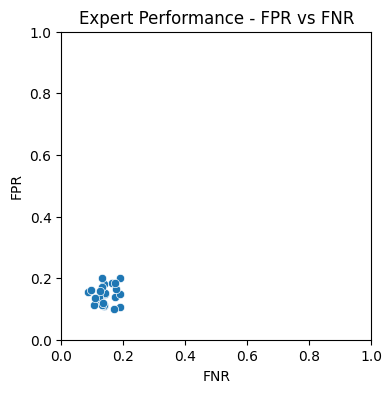

In [5]:
f, ax = plt.subplots(figsize=(4, 4))
tn, fp, fn, tp = confusion_matrix(y_pred = np.ones(len(data[LABEL_COL])), y_true = data[LABEL_COL]).ravel()
l = data_cfg['lambda']
prev = data[LABEL_COL].mean()
cost = (fn+fp*data_cfg['lambda'])/(tp+tn+fp+fn)
slope = -(prev)/(l*(1-prev))
b = cost/(l*(1-prev))
sns.scatterplot(data = metrics.reset_index(), x = 'FNR', y = 'FPR')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Expert Performance - FPR vs FNR')

Text(0.5, 1.0, 'Distribution of Expected Misclassification Cost')

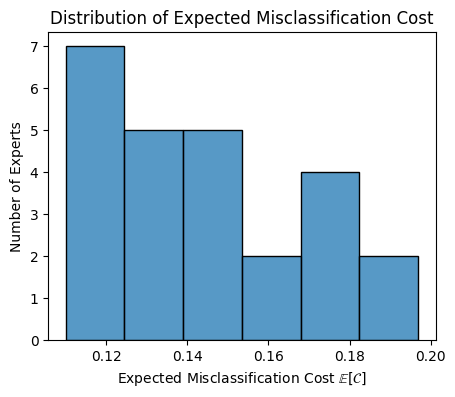

In [6]:
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = metrics['Cost'])
plt.xlabel(r"Expected Misclassification Cost $\mathbb{E}[\mathcal{C}]$")
plt.ylabel("Number of Experts")
plt.title(r"Distribution of Expected Misclassification Cost")

In [7]:
metrics

,TPR,FNR,FPR,TNR,Cost,TPR_ Female,FPR_ Female,TNR_ Female,FNR_ Female,TPR_not_ Female,...,Predictive_Equality_binarized_race,TPR_higher,FPR_higher,TNR_higher,FNR_higher,TPR_not_higher,FPR_not_higher,TNR_not_higher,FNR_not_higher,Predictive_Equality_age
standard#0,0.877231,0.122769,0.122508,0.877492,0.122573,0.874775,0.114463,0.885537,0.125225,0.877660,...,0.729809,0.851280,0.132078,0.867922,0.148720,0.887787,0.120346,0.879654,0.112213,0.754527
standard#1,0.826017,0.173983,0.138296,0.861704,0.147141,0.850809,0.237755,0.762245,0.149191,0.821679,...,1.151841,0.816106,0.112937,0.887063,0.183894,0.830049,0.144026,0.855974,0.169951,0.924180
standard#2,0.87384,0.12616,0.132504,0.867496,0.130932,0.901738,0.216029,0.783971,0.098262,0.868959,...,1.077107,0.870719,0.108311,0.891689,0.129281,0.875110,0.137971,0.862029,0.124890,0.966036
standard#3,0.860903,0.139097,0.109867,0.890133,0.117111,0.792091,0.073315,0.926685,0.207909,0.872943,...,0.629983,0.855600,0.100973,0.899027,0.144400,0.863060,0.111876,0.888124,0.136940,0.948338
standard#4,0.858315,0.141685,0.148292,0.851708,0.146654,0.865189,0.160141,0.839859,0.134811,0.857113,...,0.752941,0.877815,0.217260,0.782740,0.122185,0.850383,0.132709,0.867291,0.149617,1.224518
biased_vs_females#0,0.858762,0.141238,0.15182,0.84818,0.149197,0.182744,0.000000,1.000000,0.817256,0.977042,...,0.634217,0.883986,0.202903,0.797097,0.116014,0.848500,0.140278,0.859722,0.151500,1.305881
biased_vs_females#1,0.876784,0.123216,0.139678,0.860322,0.135598,0.312163,0.000844,0.999156,0.687837,0.975574,...,0.712916,0.886763,0.132078,0.867922,0.113237,0.872725,0.141395,0.858605,0.127275,1.123974
biased_vs_females#2,0.86242,0.13758,0.111366,0.888634,0.117863,0.122828,0.000000,1.000000,0.877172,0.991823,...,0.646875,0.893243,0.173552,0.826448,0.106757,0.849881,0.097315,0.902685,0.150119,1.406175
biased_vs_females#3,0.861527,0.138473,0.182425,0.817575,0.171532,0.291791,0.000154,0.999846,0.708209,0.961212,...,0.747511,0.879358,0.164779,0.835221,0.120642,0.854274,0.186412,0.813588,0.145726,1.207924
biased_vs_females#4,0.810671,0.189329,0.107603,0.892397,0.127858,0.258838,0.000077,0.999923,0.741162,0.907223,...,0.765434,0.820426,0.102090,0.897910,0.179574,0.806703,0.108848,0.891152,0.193297,1.076420


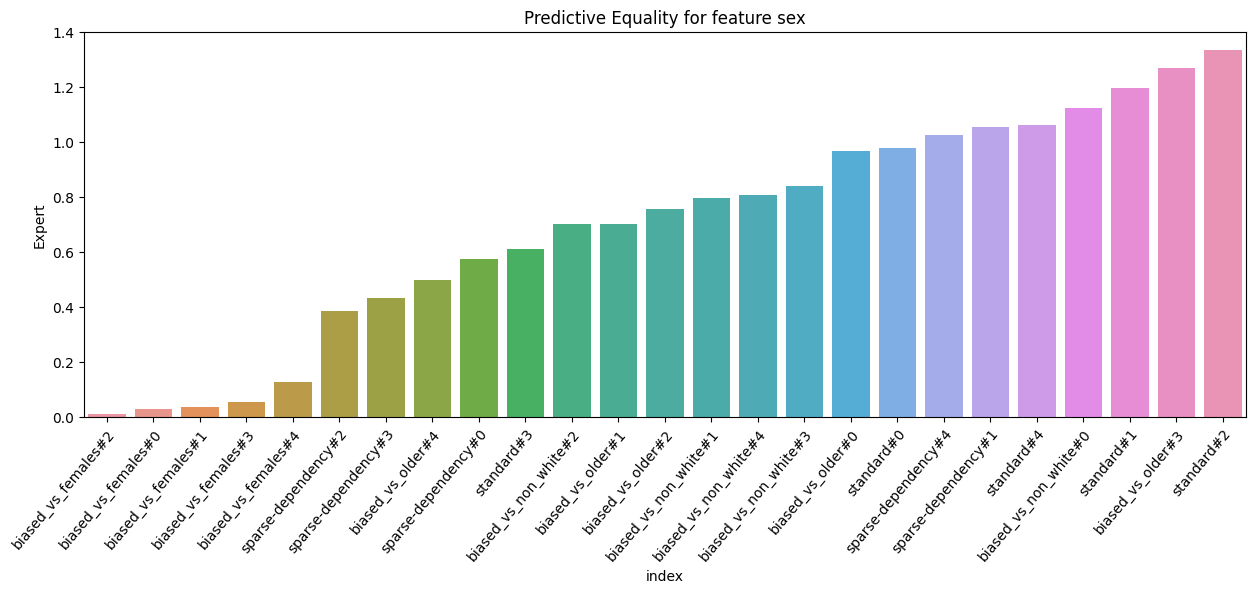

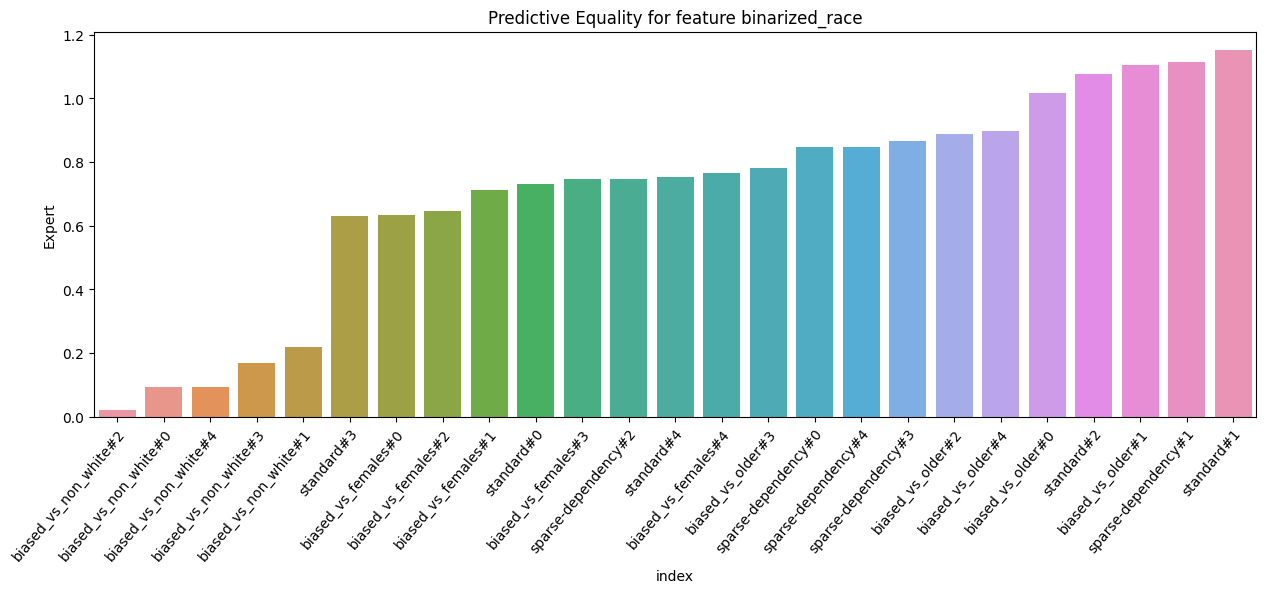

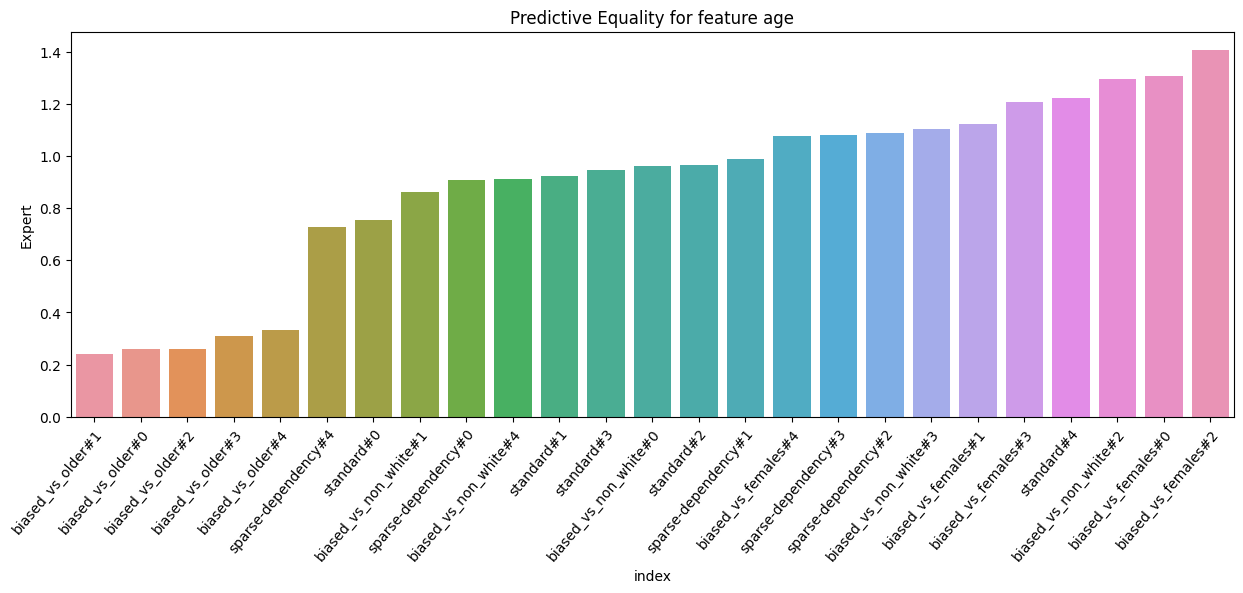

In [8]:
for feature in data_cfg['data_cols']['protected']:
    f, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(data = metrics.reset_index().sort_values(f'Predictive_Equality_{feature["feature"]}'),x = 'index', y = f'Predictive_Equality_{feature["feature"]}', dodge = False)
    plt.ylabel('Expert')
    plt.title(f'Predictive Equality for feature {feature["feature"]}')
    plt.xticks(rotation = 50, rotation_mode = 'anchor', ha = 'right')
    plt.show()

In [9]:
prop = pd.read_parquet(f'./synthetic_experts/expert_team/expert_parameters.parquet')
p_error = pd.read_parquet(f'./synthetic_experts/expert_team/prob_of_error.parquet').loc[data.index]
preds = pd.read_parquet(f'./synthetic_experts/expert_team/expert_predictions.parquet').loc[data.index]
p = pd.DataFrame()

def invert_labels_with_probabilities(labels_arr, p_arr, seed):
    rng = np.random.default_rng(seed=seed)
    mask = rng.binomial(n=1, p=p_arr).astype(bool)

    new_labels = labels_arr.copy()
    new_labels[mask] = np.abs(new_labels[mask] - 1)  # inverts labels

    return new_labels
for expert in preds.columns:
    p[expert] = p_error.loc[data.index,'p_fp_' + expert] + p_error.loc[data.index,'p_fn_' + expert]

d = dict()
for expert in preds.columns:
    temp = []
    for i in range(10):
        temp.append(invert_labels_with_probabilities(
                    labels_arr=data[LABEL_COL],
                    p_arr=p[expert],
                    seed= i))
    d[expert] = temp

k = dict()
count = 0
for expert in preds.columns:
    temp = []
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            elif i>j:
                continue

            temp.append(cohen_kappa_score(d[expert][i],d[expert][j]))
            count+=1
    
    k[expert] = temp

Text(0.5, 1.0, 'Distribution of Intra-Labeler Agreement')

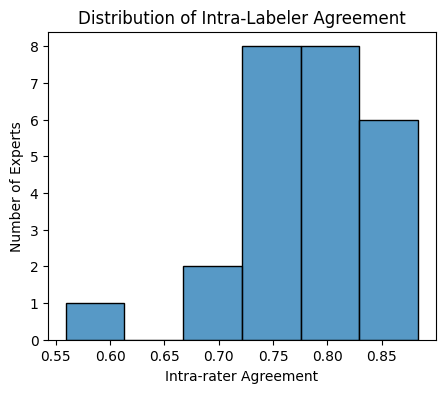

In [10]:
df = pd.DataFrame(k)
ck = df.melt().copy()
ck['alpha'] = ck.apply(lambda x: prop.loc[x['variable'],'alpha'], axis = 1)
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = ck.groupby('variable').mean()['value'])
plt.xlabel("Intra-rater Agreement")
plt.ylabel("Number of Experts")
plt.title("Distribution of Intra-Labeler Agreement")

Text(0.5, 1.0, 'Impact of $\\alpha$ on Intra-Labeler Agreement')

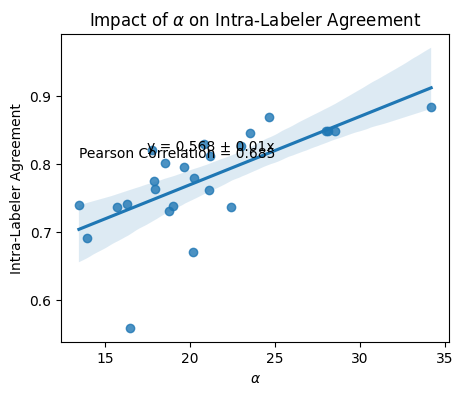

In [11]:
f, ax = plt.subplots(figsize=(5, 4))
p = sns.regplot(data = ck.groupby('variable').mean(), x = 'alpha', y = 'value')
#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#add regression equation to plot
plt.text(25, 0.82, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x', horizontalalignment = 'right')
plt.text(25, 0.81, 'Pearson Correlation = ' 
         + str(round(np.corrcoef(ck.groupby('variable').mean()['value'], ck.groupby('variable').mean()['alpha'])[0][1],3)),
         horizontalalignment = 'right')

plt.xlabel(r"$\alpha$")
plt.ylabel("Intra-Labeler Agreement")
plt.title(r"Impact of $\alpha$ on Intra-Labeler Agreement")

In [12]:
CK = pd.DataFrame(index = preds.columns, columns = preds.columns)

for expert1 in CK.columns:
    for expert2 in CK.columns:
        if expert1==expert2:
            CK.loc[expert1,expert2] = 1
            continue
        if not np.isnan(CK.loc[expert1,expert2]):
            continue
        CK.loc[expert1,expert2] = cohen_kappa_score(preds[expert1],preds[expert2])
        CK.loc[expert2,expert1] = CK.loc[expert1,expert2]

temp = []
for expert1 in CK.columns:
    for expert2 in CK.columns:
        if expert1==expert2:
            break
        else:
            temp.append(CK.loc[expert1,expert2])

print(f'Minimum: {np.min(temp)}, Maximum: {np.max(temp)}, Mean: {np.mean(temp)}')

Minimum: 0.2484199374768179, Maximum: 0.6819918229515122, Mean: 0.4479905625250776


Text(0.5, 1.0, "Distribution of Cohen's $\\kappa$ for Expert Pairs")

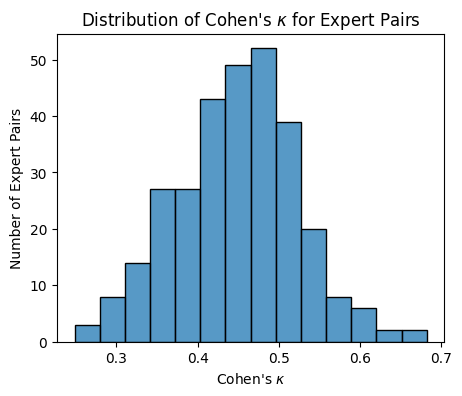

In [13]:
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = temp)
plt.xlabel(r"Cohen's $\kappa$")
plt.ylabel("Number of Expert Pairs")
plt.title(r"Distribution of Cohen's $\kappa$ for Expert Pairs")

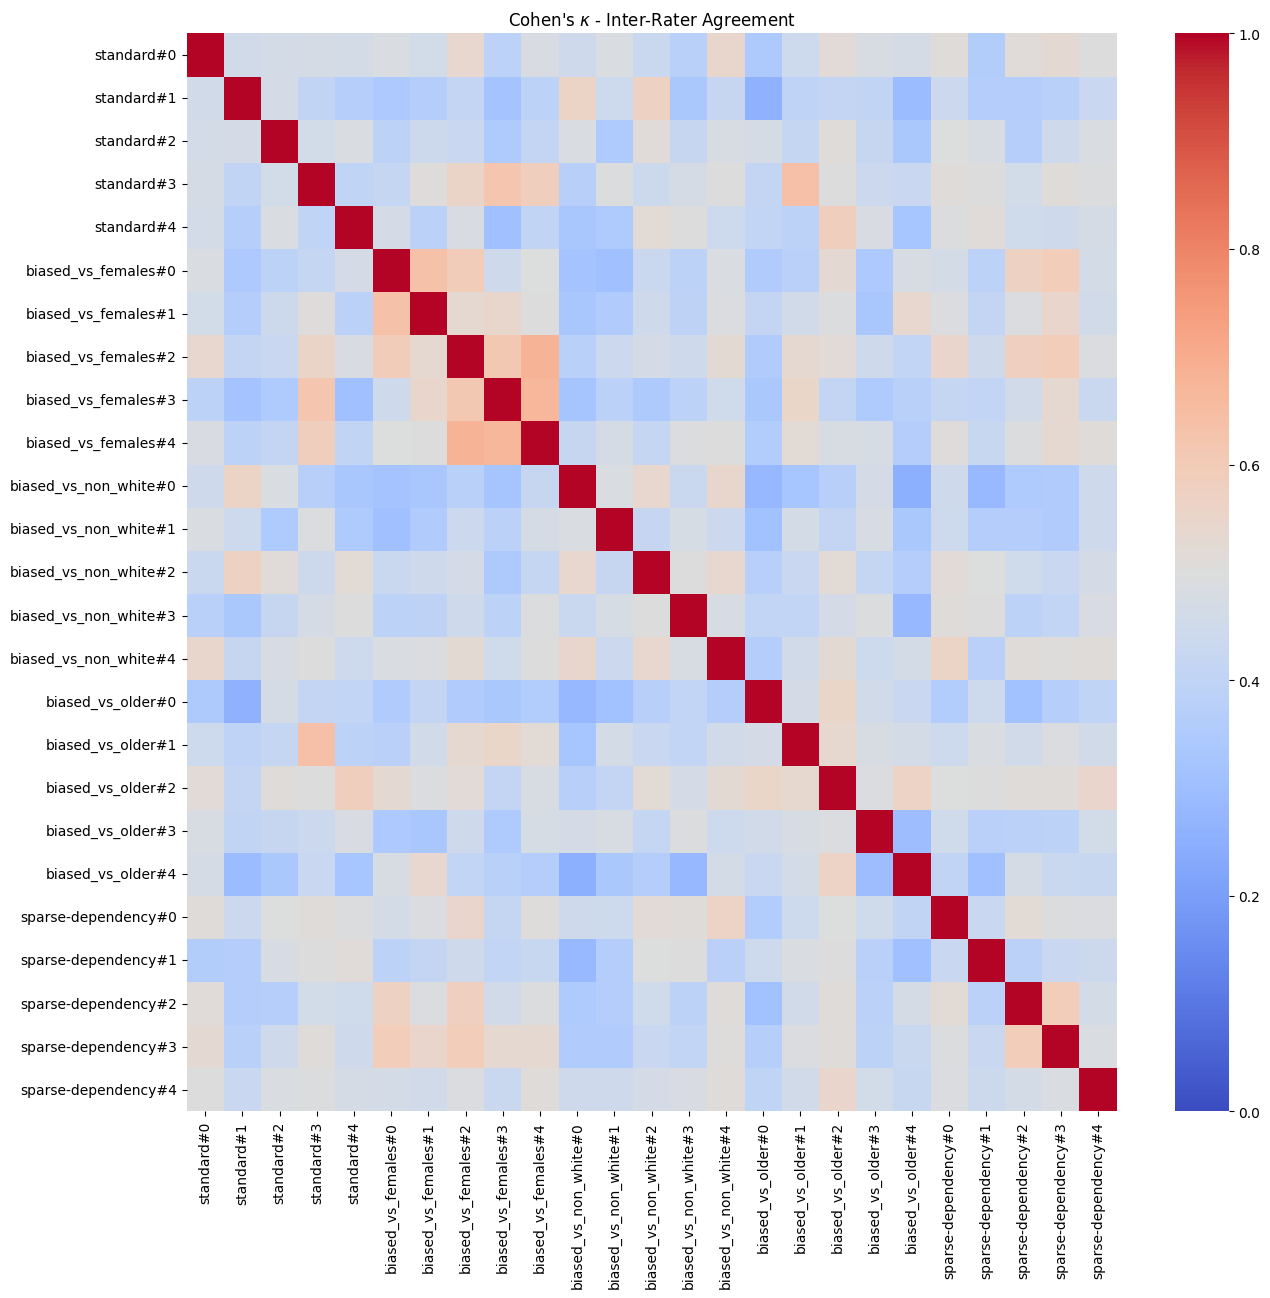

In [14]:
f, ax = plt.subplots(figsize=(15, 14))
sns.heatmap(CK.astype(float), robust=True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title(r"Cohen's $\kappa$ - Inter-Rater Agreement")
plt.show()

In [15]:
PA = pd.DataFrame(index = preds.columns, columns = preds.columns)
for expert1 in PA.columns:
    for expert2 in PA.columns:
        if expert1==expert2:
            PA.loc[expert1,expert2] = 1
            continue
        if not np.isnan(PA.loc[expert1,expert2]):
            continue
        PA.loc[expert1,expert2] = (preds[expert1] == preds[expert2]).astype(int).mean()
        PA.loc[expert2,expert1] = PA.loc[expert1,expert2]

temp = []
for expert1 in PA.columns:
    for expert2 in PA.columns:
        if expert1==expert2:
            break
        else:
            temp.append(PA.loc[expert1,expert2])

print(f'Minimum: {np.min(temp)}, Maximum: {np.max(temp)}, Mean: {np.mean(temp)}')

Minimum: 0.6604971031798682, Maximum: 0.869090265799832, Mean: 0.7584130143145666


Text(0.5, 1.0, 'Distribution of Proportion of Agreement for Expert Pairs')

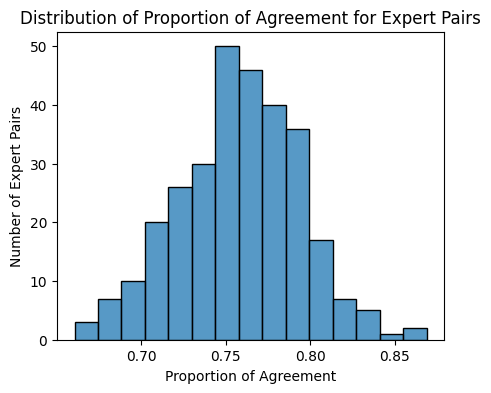

In [16]:
f, ax = plt.subplots(figsize=(5, 4))
sns.histplot(x = temp)
plt.xlabel(r"Proportion of Agreement")
plt.ylabel("Number of Expert Pairs")
plt.title(r"Distribution of Proportion of Agreement for Expert Pairs")

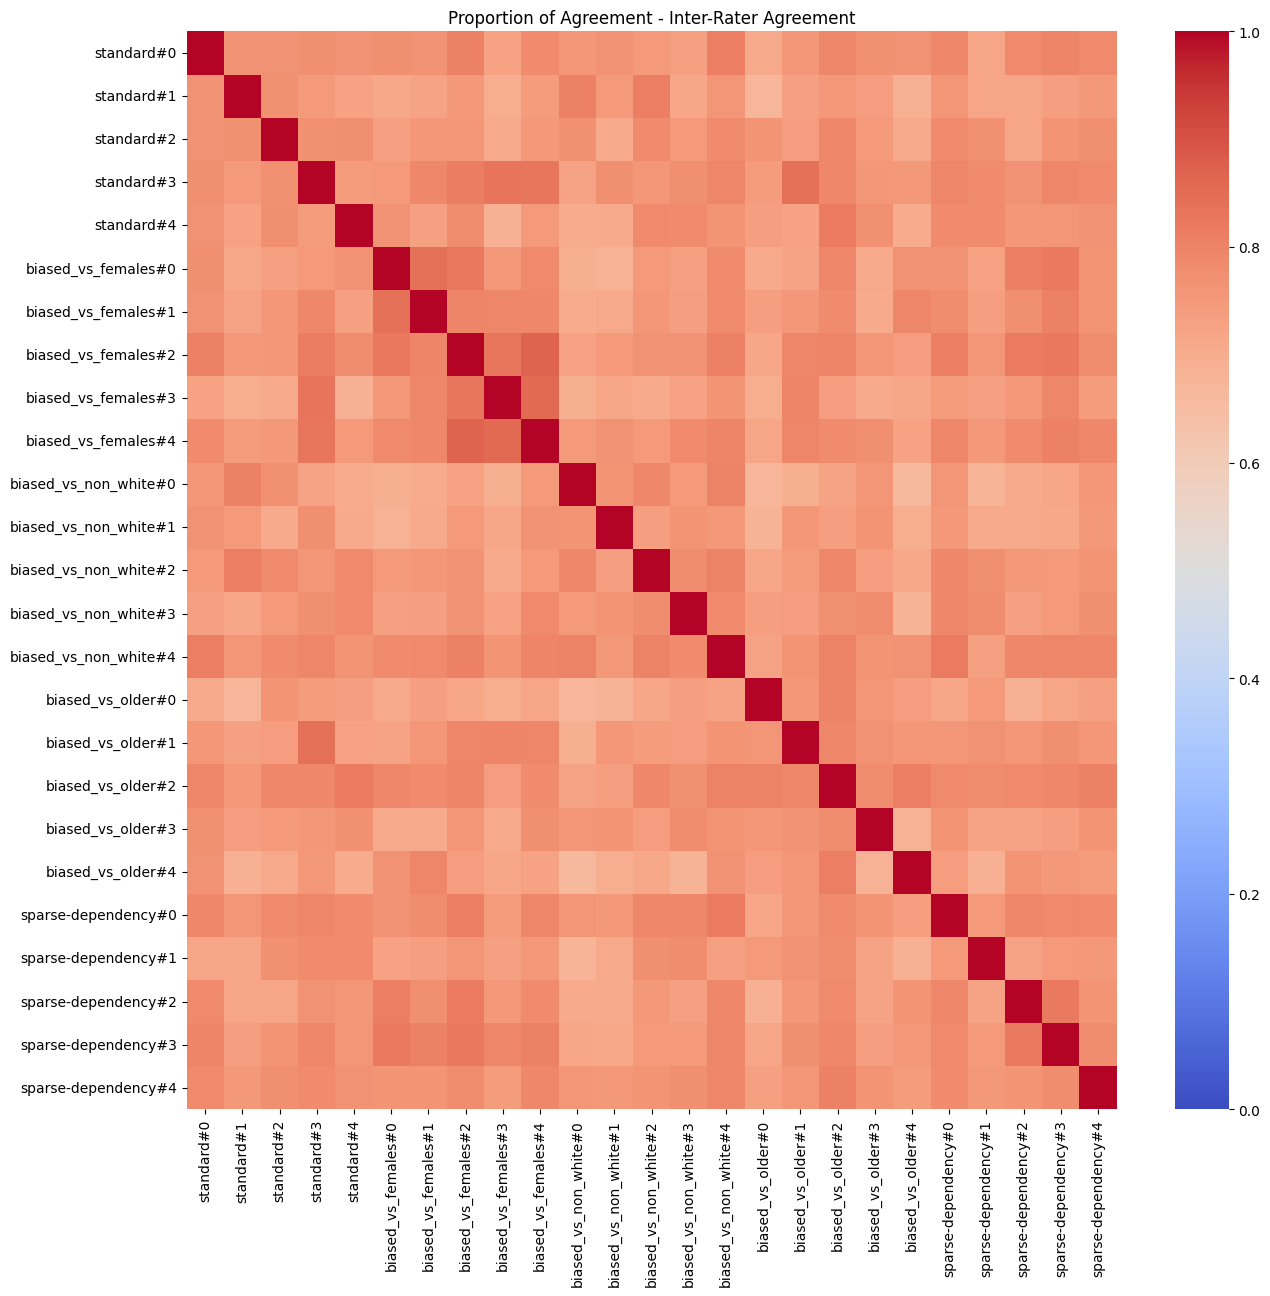

In [17]:
f, ax = plt.subplots(figsize=(15, 14))
sns.heatmap(PA.astype(float), robust=True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title(r"Proportion of Agreement - Inter-Rater Agreement")
plt.show()